## Installation

In [1]:
# # install package dependencies Seurat, scLink and dplyr
# install.packages('scLink',version='1.0.1')
# install.packages('dplyr')
# remotes::install_version("Seurat", "4.4.0")

In [2]:
# library(devtools)
# install_github("KChen-lab/transition-cells-identification",force=T)

In [3]:
library(CellTran)
options(warn=-1)

## Read data

Attaching SeuratObject

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




,orig.ident,nCount_RNA,nFeature_RNA,ClusterName
,<fct>,<dbl>,<int>,<chr>
AAACCTGAGAGGGATA-1-3,SeuratProject,156.0810,133,Fev+
AAACCTGAGGCAATTA-1-3,SeuratProject,155.5724,122,Alpha
AAACCTGGTAAGTGGC-1-3,SeuratProject,139.6293,122,Ngn3 high EP
AAACCTGTCCCTCTTT-1-3,SeuratProject,153.1265,175,Alpha
AAACGGGGTCGGGTCT-1-3,SeuratProject,145.8648,138,Alpha
AAACGGGTCAAACAAG-1-3,SeuratProject,151.7076,149,Ngn3 high EP


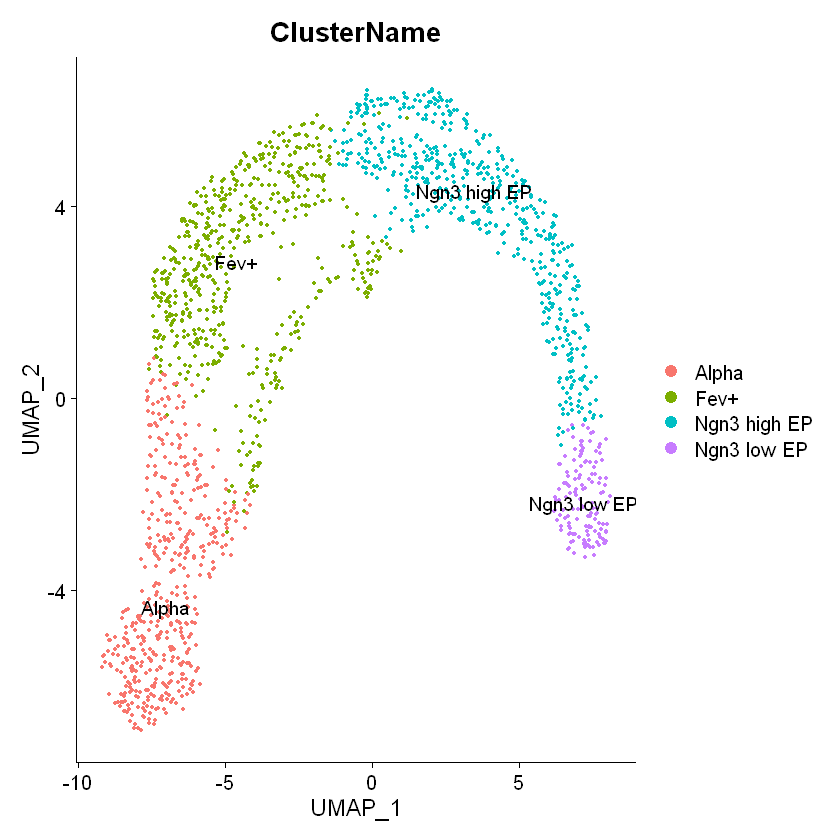

In [4]:
library(Seurat)
library(dplyr)

data_name = 'EG_single'

# (1) 读取表达矩阵（自动生成行名 "1", "2", "3"...）
counts <- read.csv(paste(data_name, "X.csv", sep = "/"), row.names = 1)  # 假设第一列是基因名

# (2) 创建 Seurat 对象
data <- CreateSeuratObject(
  counts = t(counts),          # Seurat 要求行=基因，列=细胞（需转置）
)

# (3) 添加 PCA 坐标
pca <- read.csv(paste(data_name, "pca.csv", sep = "/"), row.names = 1)
data[["pca"]] <- CreateDimReducObject(
  embeddings = as.matrix(pca), # PCA 坐标矩阵
  key = "PC_",                 # 坐标列名前缀（如 PC_1, PC_2）
  assay = "RNA"                # 关联到 RNA assay
)

# (4) 添加 UMAP 坐标
umap <- read.csv(paste(data_name, "umap.csv", sep = "/"), row.names = 1)
data[["umap"]] <- CreateDimReducObject(
  embeddings = as.matrix(umap),
  key = "UMAP_",               # 坐标列名前缀（如 UMAP_1, UMAP_2）
  assay = "RNA"
)

# (5) 添加聚类标签
clusters <- read.csv(paste(data_name, "ClusterName.csv", sep = "/"), row.names = 1)
data <- AddMetaData(
  object = data,
  metadata = clusters,
  col.name = "ClusterName"     # 元数据列名
)

# (6) 设置默认聚类标识
Idents(data) <- "ClusterName"  # 后续分析默认按此分组

# 查看结果
head(data@meta.data)
DimPlot(data, reduction = "umap", group.by = "ClusterName", label = TRUE)


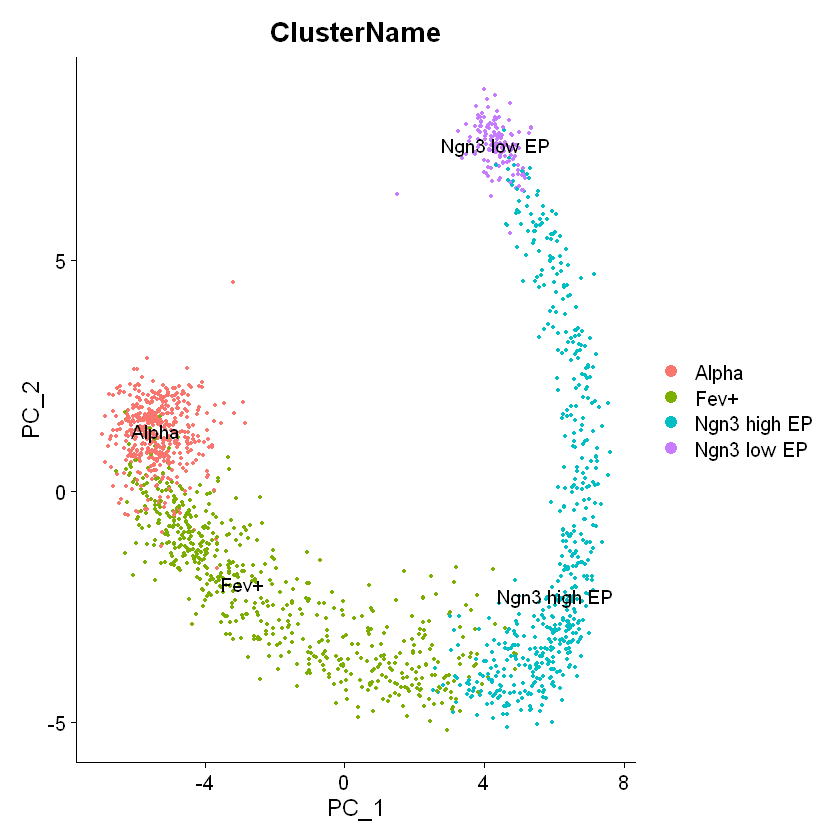

In [5]:
DimPlot(data, reduction = "pca", group.by = "ClusterName", label = TRUE)

In [6]:
data<- NormalizeData(data)
data<- ScaleData(data)
# data<- RunPCA(data, features = rownames(data))
data<- FindNeighbors(data, dims = 1: 5)
data<- FindClusters(data, resolution = 0.5)
# data<- RunUMAP(data,dims=1:5)

Centering and scaling data matrix

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1718
Number of edges: 51789

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8769
Number of communities: 8
Elapsed time: 0 seconds


In [7]:
data

An object of class Seurat 
470 features across 1718 samples within 1 assay 
Active assay: RNA (470 features, 0 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

# Calculate transition index

In [8]:
#' Calculate GPPCCs
#'
#' This is the function calculating gene pair-wise Pearson's correlation coefficients (GPPCCs). 
#' The GPPCCs calculated using our method are assumed from the cells that exhibit similar 
#' regulatory profiles and around equilibrium points. Thus, for each cell, we select the cell 
#' together with its nearest neighbors in Principal Component Analysis (PCA) dimensions based 
#' on cosine distance to calculate GPPCCs. We also use scLink in the calculation to deal with
#' the gene expression values affected by dropout. 
#' @param data Seurat object containing both count matrix and metadata such as neighboring 
#' results for a single-cell dataset.
#' @param highly_variable_gene A gene list containing top most variable genes. Calculated 
#' by \code{var} function by default.
#' @param n_neighbor The number of neighboring cells used to calculate GPPCCs. 300 by default.
#' @return A matrix of GPPCCs. Rows are cells and columns are gene pairs.
#' @import Seurat
#' @import scLink
#' @import dplyr
#' @export
gene_pearson<-function(data,highly_variable_gene=NULL,n_neighbor=300,n_gene=50,...){
        res<-NULL
        exprs<-as.matrix(GetAssayData(data))
        if(is.null(highly_variable_gene)){
                highly_variable_gene<-order(apply(as.matrix(exprs),1,function(x) var(x)),decreasing=T)[1:n_gene]
                highly_variable_gene<-rownames(exprs)[highly_variable_gene]
        }
        for(c in data %>% colnames()){
                expr<-t(exprs[highly_variable_gene,data@neighbors$RNA.nn@nn.idx[match(c,data@neighbors$RNA.nn@cell.names),]])
                pearson_cor<-scLink::sclink_cor(expr = expr, ncores = 1)
                diag(pearson_cor)<-NA
                res<-rbind(res,as.numeric(pearson_cor))
        }
        rownames(res)<-colnames(data)
        gene_name<-highly_variable_gene
        name_tmp<-character()
        for(i in gene_name){
                for(j in gene_name)
                        name_tmp<-c(name_tmp,paste(i,j,sep='_'))
         }
        colnames(res)<-name_tmp
        return(res)
}


find_ks_d<-function(x,y){
        n.x <- length(x)
        n.y <- length(y)
        w <- c(x, y)
        z <- cumsum(ifelse(order(w) <= n.x, 1/n.x, -1/n.y))
        w_sort<-sort(w)
        w_max<-max(w_sort[z==max(z)])
        z_sub<-z[w_sort>w_max]
        w_min<-min(w_sort[w_sort>w_max][z_sub==min(z_sub)])
        return(list('w_min'=w_min,'w_max'=w_max))
}

#' Calculate transition index
#'
#' This is the function calculating transition index that reflects the transition
#' probability of a cell. The transition index we defined is inspired by Kolmogorov-Smirnov 
#' statistic. We assume there are both transition cells and stable cells captured by  
#' scRNA-seq in the data. We first find the archetype of transition 
#' cell and stable cell by using modified Kolmogorov-Smirnov statistic. As proved 
#' mathematically, there are more gene pairs whose absolute value of Pearson鈥檚 
#' correlation coefficients are close to 1 in transition cells than stable cells. 
#' Thus, based on the distribution difference, by finding the maximum difference 
#' among all cells, we identify archetypal stable cells and transition cells. To 
#' count and compare the number of gene pairs exceeding such threshold in each cell, 
#' we define transition index by summarizing the percentage of gene pairs whose 
#' absolute value of Pearson鈥檚 correlation coefficients are between argmax_x(D_max)    
#' and argmin_x(D_max). 
#'
#' @param data Seurat object containing both count matrix and metadata such as neighboring 
#' results for a single-cell dataset.
#' @param highly_variable_gene A gene list containing top most variable genes. Calculated 
#' by \code{var} function by default.
#' @param group The cell group highly_variable_genes selected based on. It should be a column
#' name of data@meta.data, such as 'seurat_clusters','cell_type','time_point'. Using 
#' 'seurat_clusters' by default. 
#' @param n_neighbor The number of neighboring cells used to calculate GPPCCs. 300 by default.
#' @param n_gene The number of top most variable genes used in calculating GPPCCs. 50 by default.
#' @param return_pearson Whether report GPPCCs or not. Using False by default.
#' @return If return_pearson is False, return a Seurat object. Calculated transition index is 
#' store as a column in the metadata. If return_pearson is True, return a list. Calculated 
#' transition index is stored in the data element, as a column in the metadata. GPPCCs is stored
#' in the GPPCCs element.
#' @import Seurat
#' @import scLink
#' @import dplyr
#' @export
transition_index<-function(data,highly_variable_gene=NULL,group='seurat_clusters',n_neighbors=300,n_gene=50,return_pearson=FALSE,...){
    res<-list()
    for(i in data@meta.data[,group] %>% unique()){
            print(i)
            data_sub<-data[,data@meta.data[,group]==i]
            if(ncol(data_sub)<=n_neighbors)
                    next
            data_sub<-Seurat::FindVariableFeatures(data_sub, selection.method = "vst", nfeatures = 2000)
            data_sub<- Seurat::ScaleData(data_sub,vars.to.regress="nCount_RNA")
            data_sub<- Seurat::RunPCA(data_sub, features = VariableFeatures(object = data_sub),npcs=min(20,ncol(data_sub)))
            data_sub<- Seurat::FindNeighbors(data_sub, dims = 1: min(20,ncol(data_sub)),return.neighbor = TRUE,k.param=n_neighbors,annoy.metric='cosine')
            pearson<-gene_pearson(data_sub,highly_variable_gene=highly_variable_gene,n_neighbor=n_neighbors,n_gene=n_gene)
            # fine tuning  (optional)
            pearson<-abs(pearson)
            res_1<-apply(pearson,1,function(x) ks.test(x,pearson[1,],alternative='greater')$statistic)
            res_2<-apply(pearson,1,function(x) ks.test(x,pearson[1,],alternative='less')$statistic)
            res_tmp<-find_ks_d(pearson[which.max(res_1),],pearson[which.max(res_2),])
            tmp<-apply(pearson,1,function(x) sum(abs(x)>min(unlist(res_tmp)) & abs(x)<max(unlist(res_tmp)),na.rm=T)/sum(abs(x)>=0,na.rm=T))
            data_sub<-Seurat::AddMetaData(data_sub,data.frame('pearson'=tmp))
            if(min(tmp)==max(tmp)){
                    res[[as.character(i)]]<-pearson
                    next
            }
            cell<-data_sub@meta.data %>% dplyr::filter(pearson>quantile(data_sub$pearson,0.8,na.rm=T)) %>% rownames()
            hvg<-sort(apply(as.matrix(GetAssayData(data_sub[,cell])),1,function(x) var(x)),decreasing=T)[1:n_gene] %>% names
            pearson<-gene_pearson(data_sub,n_neighbor=n_neighbors,highly_variable_gene=hvg)
            res[[as.character(i)]]<-pearson
    }
    res<-Reduce(function(x,y) rbind(x,y),res)
    pearson<-res
    res<-abs(res)
    res_1<-apply(res,1,function(x) ks.test(x,res[1,],alternative='greater')$statistic)
    res_2<-apply(res,1,function(x) ks.test(x,res[1,],alternative='less')$statistic)
    res_tmp<-find_ks_d(res[which.max(res_1),],res[which.max(res_2),])
    tmp<-apply(res,1,function(x) sum(abs(x)>min(unlist(res_tmp)) & abs(x)<max(unlist(res_tmp)),na.rm=T)/sum(abs(x)>=0,na.rm=T))
    data<-Seurat::AddMetaData(data,data.frame('transition_index'=tmp))
    if(!return_pearson)
    return(data)
    else
    return(list('GPPCCs'=pearson,'data'=data))
}


In [12]:
# calculate transition index
data<-transition_index(data,n_neighbor=30,n_gene=100)

[1] "1"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  Hpcal1, Fev, Nkx6.1, Pax4, Npepl1, Pdk3, Flrt1, Tubb3, Inppl1, Hpca 
	   Miat, Neurog3, Rbfox3, Mfng, Hn1, Sulf1, BC023829, Smarcd2, Slc25a5, Hes6 
	   Gspt1, Fam159a, Gdpd1, Lingo1, Cck, Pcsk1n, Hpgd, Neurod2, Selm, Pcyt1b 
Negative:  Tmem27, Ghr, Peg10, Ank, Slc16a10, Scgn, Syne1, Mboat4, Slc38a5, Id2 
	   Rbp4, Rai2, X1700086L19Rik, Sema3c, Auts2, Ppy, Immp1l, Acvr1c, Hhex, Upk3bl 
	   Gm609, Arx, Ush1c, Ap1s2, Hap1, X1500009L16Rik, Abcc8, Klhl13, Fgf12, Ppp1r14c 
PC_ 2 
Positive:  Mdk, Mboat4, Upk3bl, Elavl4, Hpca, Ifitm2, Igfbpl1, X1810041L15Rik, Dll3, Apoc1 
	   Pak3, Hhex, Col9a3, Gm609, Mia, Cck, Col18a1, Dner, Neurod2, Dbn1 
	   BC023829, Sema3c, Trim35, Btg2, Mfng, Btbd17, Smarcd2, Mboat1, Selm, Muc1 
Negative:  BC048546, Fxyd6, Aard, Entpd3, Rab3b, Apbb1, Ncam1, Tmem163, Resp18, Hist1h2bc 
	   Camk2b, Nkx6.1, Parm1, Prps1, Ociad2, Ocrl, Papss2, Pon3, Dcdc2a, Adgb 
	   A1cf, Gm1673, Hap1, Hprt, Ga

[1] "6"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  Fxyd6, Prrg2, Mlxipl, Gch1, Smpdl3a, Usp18, Hap1, Ppp1r14c, Cyp4b1, Cryba2 
	   Tm4sf4, BC023829, Fev, Csrp2, Id2, Rab3b, Ppp3ca, Entpd3, Fam183b, Rap1b 
	   Emb, Gnai1, Mpzl1, Gars, Chst8, A1cf, Ica1, Glud1, Anxa4, Igsf8 
Negative:  Pou6f2, Pcsk2, Ctsz, Ppy, Igfbp7, Higd1a, Ppp1r1a, Selm, Tmsb15l, Hpgds 
	   Pcsk1n, Wnk3, Btbd17, Ncoa7, Slc2a5, Rbp4, G630016G05Rik, S100a11, Ank, G6pc2 
	   Auts2, Ptprn, Mia, Bcl2l14, Mt1, Hes6, Rap1gapos, St6galnac5, Sesn3, Resp18 
PC_ 2 
Positive:  Ncam1, Serpine2, Cbfa2t3, Ociad2, Gnaz, Papss2, Ncoa7, S100a11, Dock11, Gk 
	   Hprt, Pdgfa, Gnai1, Higd1a, Rap1gapos, Enc1, Nqo1, Dtnbos, Ndc1, Slc30a8 
	   Cotl1, Ctsz, Eya2, Gm609, Mum1l1, H19, Ripply3, Tmem27, Igfbp7, Slc16a10 
Negative:  Gsta3, Cdc42ep1, Mnx1, Hif3a, Cyr61, Kirrel2, Rasl11b, Flrt2, Cmtm8, Zbtb18 
	   Chst8, Rbfox3, Tead2, Gadd45a, Grin2c, Lamb1, Igf2, Vil1, Sel1l, Tmem108 
	   Miat, G630016G05Rik, Rfwd3, S

[1] "2"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  Btbd17, Ppp1r14a, Neurod2, Upk3bl, Ttc28, Cdk2ap1, Tead2, Tmsb4x, Gadd45a, X1810041L15Rik 
	   Cldn6, Amotl2, Cbfa2t3, Hn1, Foxa3, Mmd2, Hpca, Fam107b, Tbc1d9, Arx 
	   Neurog3, Rab15, Mdk, Carhsp1, Selm, Ifitm2, Sult2b1, Tubb3, Slc16a5, Lrrtm3 
Negative:  Fev, Gch1, Pcsk1n, Cryba2, Rbp4, Pax6, Slc25a5, Rap1b, Cpe, Fxyd6 
	   Akr1c19, X1700086L19Rik, Pam, Hap1, Tmem163, Gm43861, BC048546, Vdr, Pcsk2, Tmem27 
	   Cyp4b1, Gnaz, Tspan7, Rnf130, Fam183b, Ffar4, Prrg2, Smpdl3a, Rab27a, Scg3 
PC_ 2 
Positive:  Mboat4, Muc1, Gch1, St8sia2, Ghr, Scgn, Fam151a, Akr1c19, Cxxc4, Irx2 
	   Lrrtm3, Arx, Hhex, Meis2, Fam107b, Cdkn1c, A1cf, Id2, Ppy, Ffar4 
	   Sema3c, Auts2, Tspan12, Eno1, Lamb1, Gm43194, Gas6, Nqo1, Rab27a, Akr1c12 
Negative:  Pax4, Nkx6.1, Hpcal1, Fev, Gspt1, Slc25a5, Lhx1os, Flrt1, Tubb3, Casz1 
	   Neurog3, Gadd45a, Npepl1, Gars, Cryba2, Lingo1, Epb42, Sept3, Tmbim1, Fxyd6 
	   Gm43861, Sulf1, Cbfa2t

[1] "0"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  Id2, Usp18, Ppp1r14c, Parm1, Muc1, Smpdl3a, Tm4sf4, Anxa4, Arx, Hap1 
	   Emb, Mctp2, BC023829, Gars, Tmem163, Akr1c19, Csrp2, Prrg2, Syne1, Rap1b 
	   Pcyt1b, Cxxc4, Cryba2, Myl12a, Pax6, Mlxipl, Fam183b, Glud1, Chst8, Fev 
Negative:  Pcsk2, Tmsb4x, Hist1h2bc, Slc7a2, Tmsb15l, Ppp1r1a, Slc30a8, Gpx3, Gm1673, Ctsz 
	   Sct, Igfbp7, Resp18, Pcsk1n, Emid1, Cpn1, Irx2, S100a11, Gpx7, Selm 
	   Sesn3, Olfm1, Wnk3, Prdx4, Tuba1a, Ctsl, Rap1gapos, Tspan7, Gapdh, Sphkap 
PC_ 2 
Positive:  Col9a3, Anxa2, Mdk, Adk, Gm8113, Pou6f2, Gstt2, Pam, Tecr, Selenbp1 
	   Cyba, Atp1b1, Nap1l5, Prdx4, Mboat4, Adamts1, Pdlim1, Ctsz, Prom1, Cdc42ep1 
	   Apoc1, Slc16a10, Cck, Myl12a, Lamb1, Qsox1, Hhex, Ifitm2, Klhl13, Csrp2 
Negative:  Ppp1r1a, Npepl1, Slc30a8, Chic1, Pak3, X1700086L19Rik, Vdr, Rap1b, Cryba2, Nqo1 
	   Fev, Lhx1os, Ffar4, Myt1l, Hpgd, Scg3, Rab27a, Pcsk1n, Pim2, G6pc2 
	   Pcsk2, Gnai1, Mlxipl, Pdx1, Tmem108, T

[1] "4"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  Spp1, Muc1, Dbi, Krt18, Sdsl, Aldh1b1, Dll1, Gsta3, Clu, Litaf 
	   Mt1, Wfdc15b, Acot1, Calml4, Mpzl1, Anxa2, S100a11, Fgfr1, Ass1, Prdx4 
	   Col18a1, Wsb1, Spink4, Nptx2, Prmt3, Pah, Pebp1, H19, Cyba, Adamts1 
Negative:  Neurod2, Tubb3, Miat, Cck, Olfm1, Hpca, BC023829, Tuba1a, Mfng, Ppp1r14a 
	   Dbn1, Chn2, Ppp3ca, Emid1, Igfbpl1, Dner, Shf, Upk3bl, Rbfox3, Mdk 
	   Sms, Hn1, X1810041L15Rik, Selm, Rab15, Epb42, Slc25a5, Sult2b1, Grin2c, Kcnb2 
PC_ 2 
Positive:  Ghr, Adgrg6, St8sia2, Irx2, Gpm6b, Ncoa7, Meis2, Klhdc8b, Tmem108, Mboat4 
	   Akr1c19, X1810041L15Rik, Elavl4, Pon3, Apbb1, Rap1b, Ica1, Gm1673, Fam210b, Zfhx3 
	   Sh2d4a, Dtnbos, Gm42637, Pdk3, Pamr1, Fblim1, X1700086L19Rik, Celf4, Hs6st1, Ccl4 
Negative:  Smarcd2, Ttc28, Gpx2, Lmna, Csrp2, Elf5, Efhd2, Ncs1, Hpcal1, Trp53i11 
	   Cbfa2t3, Txndc5, Slc7a5, Fermt1, Emb, Mpzl1, Slc31a2, Usp18, Dpysl3, Gpc3 
	   Hes1, Akr1c13, Hrsp12, Amotl1, Fgf

[1] "5"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  Id2, Bicc1, Hhex, Cyr61, St3gal4, Atp1b1, Krt19, Sbspon, Cdc42ep1, Selenbp1 
	   Hmga2, Hpgd, Adk, Mal2, Col27a1, Sh2d4a, Nfib, Mt1, Fgfr2, Igsf3 
	   Dcdc2a, Hebp1, Myl12a, S100a10, Gpm6b, Myl12b, Slc2a2, Fkbp2, Sox9, Gapdh 
Negative:  Cbfa2t3, Tff3, Dll1, Grin3a, Mpzl1, Amotl2, Numbl, Foxa3, Btbd17, Nptx2 
	   Cdk2ap1, Neurog3, Prom1, Lingo1, Btg2, Qsox1, Pax4, Fam151a, Abcc8, Nfix 
	   Wsb1, Aldh1b1, Lrrn2, Grasp, Ppp1r14a, Epb42, Gpx2, Calml4, Cotl1, Mfng 
PC_ 2 
Positive:  X1700086L19Rik, Ncam1, Dtnbos, Tmem163, Shf, Pim2, Cpe, Muc1, Sel1l, Bcl2l14 
	   Foxa3, Hprt, Col27a1, Lmna, Kcnq4, Zbtb20, Igsf8, Ddah1, Clu, Ezr 
	   Parm1, Galm, Fam174a, Glud1, Grasp, Net1, Immp1l, Gas6, Prps1, Dpp4 
Negative:  Ifitm2, Spp1, Selm, Myl12b, Atox1, Col18a1, Ptn, Col9a3, Gm1673, Calml4 
	   Nkx6.1, Vdr, Mmd2, Cxxc4, Ctsz, Ppib, Smoc1, Fscn1, Gpx2, Efhd2 
	   Cyba, Tspan7, Aldh1b1, Tpm4, Cdkn1c, Anxa2, Inppl1, Sparc,

[1] "3"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  Clu, Cdc14b, E2f1, Sparc, Tmsb4x, Eya2, Trp53i11, Acot1, Mpzl1, S100a11 
	   Slc7a5, Tmem51, H19, Acaa2, Snrk, Fstl1, Cdkn1c, Slc2a5, Emid1, Gadd45a 
	   Lrrn2, Tff3, Slc31a2, Mdk, Nek6, Sel1l, Ccnjl, Wrap73, Higd1a, Igf1r 
Negative:  St18, Cpe, Pax6, Tm4sf4, Emb, Arx, Meis2, Tuba1a, Fam183b, Necab2 
	   Gm43861, BC023829, Klhdc8b, Akr1c19, Glud1, Gspt1, Lhx1os, Pdx1, Pcsk1n, Scg3 
	   Elavl4, Scg5, Pcsk2os1, Akr1c13, Gars, Pak3, St8sia2, Pcyt1b, Dner, X1700086L19Rik 
PC_ 2 
Positive:  Pax4, Hpcal1, X1810041L15Rik, Gadd45a, Neurog3, Krt19, BC023829, Flrt1, Kirrel2, Mfng 
	   Trp53i11, Foxa3, Tmem51, Dbn1, Cryba2, Gm43861, Lhx1os, Tuba1a, Gars, Rab15 
	   Miat, Cbfa2t2, Myl12a, Fras1, Zbtb18, Olfm1, Mlxipl, E2f1, Fxyd6, Pax6 
Negative:  Fam151a, Gm43194, Mboat4, Fam107b, Nptx2, Tm4sf4, Tmsb15l, Jade1, Tff3, Smarca1 
	   Gpc3, Ctsl, Fam174a, Scin, Gch1, Col27a1, Wapl, Lrrtm3, Sms, Spp1 
	   Tmem27, Sema3c, Ar

[1] "7"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  Resp18, Gk, X1700086L19Rik, Gch1, Syne1, Flrt1, Serpine2, Mgll, Hist1h2bc, Akr1c12 
	   Gsta3, S100a10, Pkp4, S100a11, Atp1b1, Fras1, Ccnjl, Gars, Rap1b, Adamts1 
	   Gas2, Spp1, Cdk6, Rhoj, Cat, Hebp1, Spsb4, Spr, Igsf8, Mt1 
Negative:  Btg2, Mif, Prom1, Idh2, Zbtb20, Nptx2, Wfdc15b, Emid1, Glud1, Litaf 
	   Inppl1, Lzts1, Upk3bl, Tubb3, Pax4, Sox9, Slc39a2, Gm42637, Tm4sf4, Rbfox3 
	   Fam174a, Tspear, Qsox1, Tenm4, X1810041L15Rik, Tff3, Muc1, Fscn1, Bcl2l14, Ppp3ca 
PC_ 2 
Positive:  Pcyt1b, Paqr5, Ppy, Smpdl3a, Smarca1, Dpp4, Adamts16, Gm42637, Pam, Flrt1 
	   Ush1c, Fermt1, Pon3, Ezr, Ppib, Parm1, Igf1r, Tead2, Hist1h2bc, Hpgd 
	   Sulf2, Fgfr2, Fgf12, Tspan7, Fstl1, Rbp4, Tcf7l2, Prkacb, Grin3a, Pdk3 
Negative:  Idh2, Gm8113, Hprt, Spp1, Ambp, Pdgfa, Lmna, Lipc, Mpzl1, H19 
	   Pamr1, Btbd17, Rnf128, Anxa2, Sat1, Bicc1, Prrg2, Wwc1, Blnk, Nfib 
	   Rasl11b, Apoc1, Eno1, Pdlim1, Mal2, Akr1c13, Dcdc2a, 

##Visualization

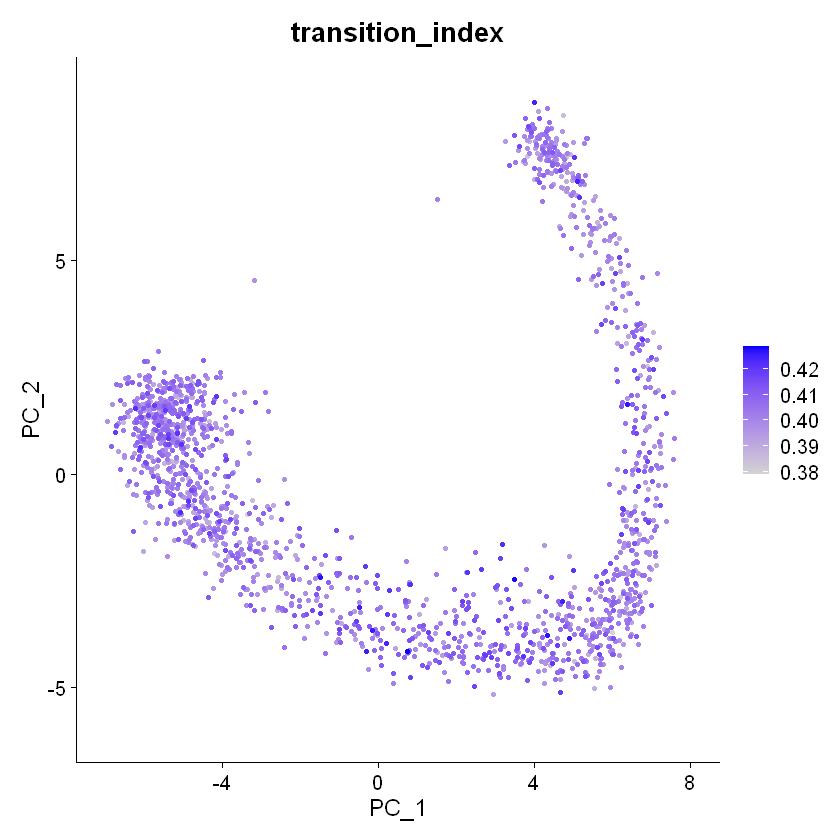

In [13]:
# PCA 按 Transition Index 着色
FeaturePlot(data, reduction = "pca", features = 'transition_index', order = TRUE, pt.size = 1)

In [14]:
write.table(data$transition_index, 
            file = paste(data_name, "/transition_index.csv", sep = '/'),
            row.names = FALSE,
            col.names = FALSE,
            sep = ",")